Solving Poisson equation using finite difference method

Solving on 50x50 grid...

Error statistics:
----------------------------------------
Maximum absolute error: 3.422703e-04
Mean absolute error: 1.332694e-04
L2 norm of error: 1.678849e-04
Maximum relative error: 0.03%

Plotting graphs...


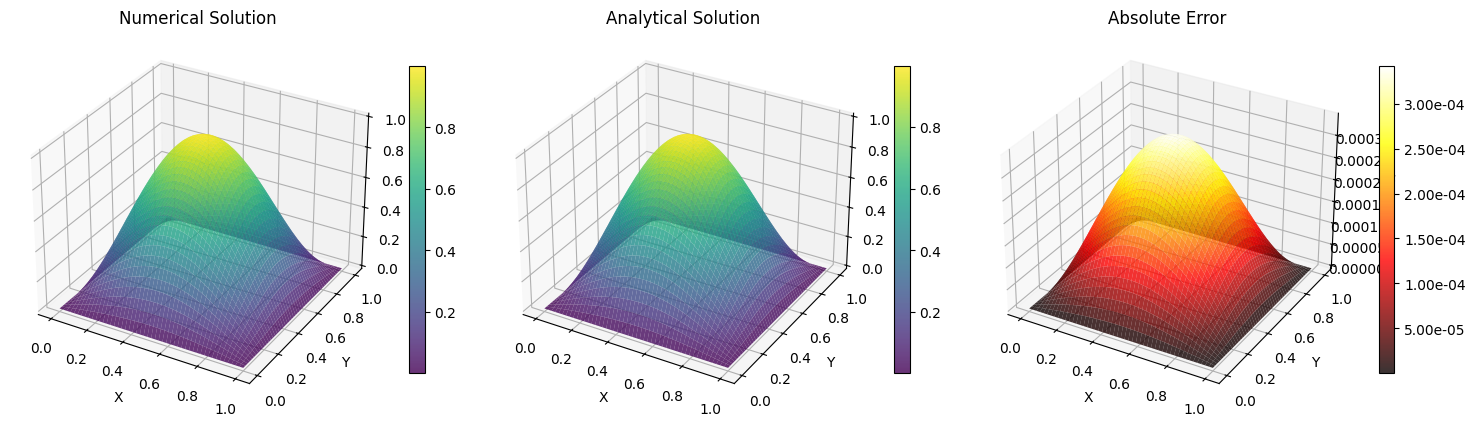


Method convergence study...


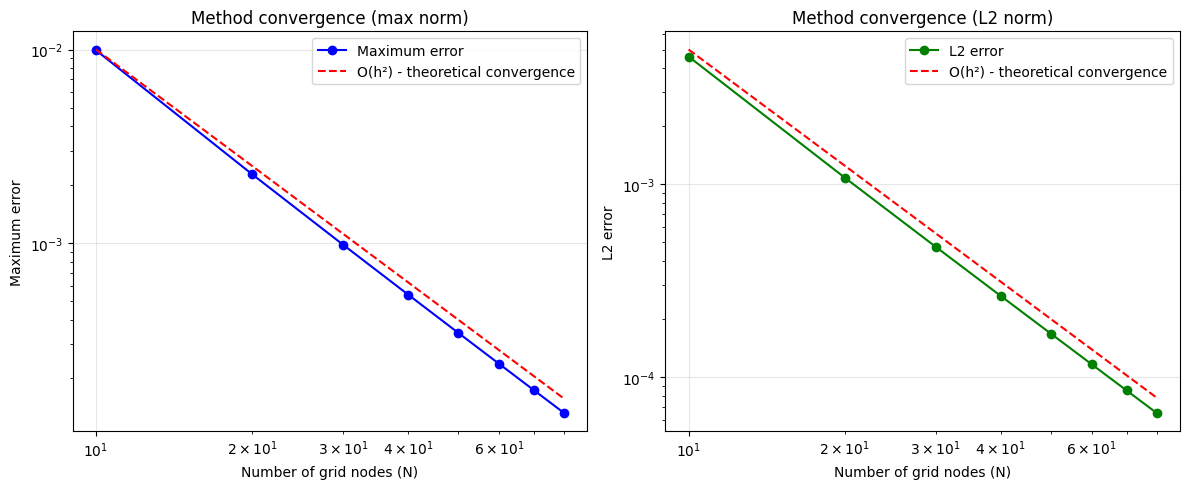


Convergence order:
--------------------------------------------------
         N       Max Error      Order        L2 Error      Order
--------------------------------------------------
        10    9.908023e-03        ---    4.597234e-03        ---
        20    2.265862e-03      2.129    1.083674e-03      2.085
        30    9.756692e-04      2.078    4.729597e-04      2.045
        40    5.400395e-04      2.056    2.636968e-04      2.031
        50    3.422703e-04      2.044    1.678849e-04      2.023
        60    2.361392e-04      2.036    1.161841e-04      2.019
        70    1.726793e-04      2.030    8.515034e-05      2.016
        80    1.317428e-04      2.026    6.507374e-05      2.014

Done!


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def solve_poisson_2d(nx=50, ny=50, Lx=1.0, Ly=1.0):
    """
    Solving 2D Poisson equation: ∇²u = f(x,y)
    with Dirichlet boundary conditions u = 0 on the boundary
    
    Using a test problem with known analytical solution:
    f(x,y) = -2π² * sin(πx) * sin(πy)
    u_exact(x,y) = sin(πx) * sin(πy)
    """
    
    # Grid steps
    dx = Lx / (nx - 1)
    dy = Ly / (ny - 1)
    
    # Create grid
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X, Y = np.meshgrid(x, y)
    
    # Right-hand side of the equation (source term)
    def f(x, y):
        return -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)
    
    # Analytical solution for comparison
    def u_exact(x, y):
        return np.sin(np.pi * x) * np.sin(np.pi * y)
    
    # Formation of linear system Au = b
    # Using lexicographic node numbering
    N = (nx - 2) * (ny - 2)  # Number of internal nodes
    
    # Create sparse matrix A
    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(N)
    off_diag_x = (1/dx**2) * np.ones(N-1)
    off_diag_y = (1/dy**2) * np.ones(N-(nx-2))
    
    # Zero elements at block boundaries (for correct matrix structure)
    for i in range(nx-3, N-1, nx-2):
        off_diag_x[i] = 0
    
    # Build matrix A
    A = diags([off_diag_y, off_diag_x, main_diag, off_diag_x, off_diag_y],
              [-(nx-2), -1, 0, 1, nx-2], shape=(N, N), format='csr')
    
    # Form right-hand side vector b
    b = np.zeros(N)
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            idx = (j-1) * (nx-2) + (i-1)
            b[idx] = f(x[i], y[j])
    
    # Solve the linear system
    u_inner = spsolve(A, b)
    
    # Reconstruct full solution with boundary conditions
    u_numerical = np.zeros((ny, nx))
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            idx = (j-1) * (nx-2) + (i-1)
            u_numerical[j, i] = u_inner[idx]
    
    # Calculate analytical solution
    u_analytical = u_exact(X, Y)
    
    # Calculate error
    error = np.abs(u_numerical - u_analytical)
    relative_error = error / (np.max(np.abs(u_analytical)) + 1e-10)
    
    return X, Y, u_numerical, u_analytical, error, relative_error

def plot_results(X, Y, u_numerical, u_analytical, error, relative_error):
    """Visualization of results"""
    
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Numerical solution
    ax1 = fig.add_subplot(2, 3, 1, projection='3d')
    surf1 = ax1.plot_surface(X, Y, u_numerical, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('u')
    ax1.set_title('Numerical Solution')
    plt.colorbar(surf1, ax=ax1, shrink=0.5)
    
    # 2. Analytical solution
    ax2 = fig.add_subplot(2, 3, 2, projection='3d')
    surf2 = ax2.plot_surface(X, Y, u_analytical, cmap='viridis', alpha=0.8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('u')
    ax2.set_title('Analytical Solution')
    plt.colorbar(surf2, ax=ax2, shrink=0.5)
    
    # 3. Absolute error
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    surf3 = ax3.plot_surface(X, Y, error, cmap='hot', alpha=0.8)
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Error')
    ax3.set_title('Absolute Error')
    plt.colorbar(surf3, ax=ax3, shrink=0.5, format='%.2e')
    
    plt.tight_layout()
    plt.show()

def convergence_study():
    """Method convergence study"""
    
    grid_sizes = [10, 20, 30, 40, 50, 60, 70, 80]
    max_errors = []
    l2_errors = []
    
    for n in grid_sizes:
        X, Y, u_num, u_ana, error, _ = solve_poisson_2d(nx=n, ny=n)
        max_errors.append(np.max(error))
        l2_errors.append(np.sqrt(np.mean(error**2)))
    
    # Convergence plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Maximum error
    ax1.loglog(grid_sizes, max_errors, 'bo-', label='Maximum error')
    ax1.loglog(grid_sizes, [1/n**2 for n in grid_sizes], 'r--', 
               label='O(h²) - theoretical convergence')
    ax1.set_xlabel('Number of grid nodes (N)')
    ax1.set_ylabel('Maximum error')
    ax1.set_title('Method convergence (max norm)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # L2 error
    ax2.loglog(grid_sizes, l2_errors, 'go-', label='L2 error')
    ax2.loglog(grid_sizes, [0.5/n**2 for n in grid_sizes], 'r--', 
               label='O(h²) - theoretical convergence')
    ax2.set_xlabel('Number of grid nodes (N)')
    ax2.set_ylabel('L2 error')
    ax2.set_title('Method convergence (L2 norm)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate convergence order
    print("\nConvergence order:")
    print("-" * 50)
    print(f"{'N':>10} {'Max Error':>15} {'Order':>10} {'L2 Error':>15} {'Order':>10}")
    print("-" * 50)
    
    for i in range(len(grid_sizes)):
        if i == 0:
            print(f"{grid_sizes[i]:>10} {max_errors[i]:>15.6e} {'---':>10} {l2_errors[i]:>15.6e} {'---':>10}")
        else:
            order_max = np.log(max_errors[i-1]/max_errors[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
            order_l2 = np.log(l2_errors[i-1]/l2_errors[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
            print(f"{grid_sizes[i]:>10} {max_errors[i]:>15.6e} {order_max:>10.3f} {l2_errors[i]:>15.6e} {order_l2:>10.3f}")


print("Solving Poisson equation using finite difference method")
print("=" * 60)

# Solution with 50x50 grid
print("\nSolving on 50x50 grid...")
X, Y, u_numerical, u_analytical, error, relative_error = solve_poisson_2d(nx=50, ny=50)

# Output error statistics
print("\nError statistics:")
print("-" * 40)
print(f"Maximum absolute error: {np.max(error):.6e}")
print(f"Mean absolute error: {np.mean(error):.6e}")
print(f"L2 norm of error: {np.sqrt(np.mean(error**2)):.6e}")
print(f"Maximum relative error: {np.max(relative_error):.2%}")

# Visualization of results
print("\nPlotting graphs...")
plot_results(X, Y, u_numerical, u_analytical, error, relative_error)

# Convergence study
print("\nMethod convergence study...")
convergence_study()

print("\nDone!")